In [1]:
!pip install cleantext

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sainitishmitta04/23k-reddit-gaming-comments-with-sentiments-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/23k-reddit-gaming-comments-with-sentiments-dataset


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean_words, clean
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

2025-08-30 12:42:22.175425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756557742.545846      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756557742.648904      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
os.listdir("/kaggle/input/23k-reddit-gaming-comments-with-sentiments-dataset")

['23k_r_gaming_comments_sentiments.csv', 'cleaned_comments.csv']

In [5]:
df = pd.read_csv("/kaggle/input/23k-reddit-gaming-comments-with-sentiments-dataset/23k_r_gaming_comments_sentiments.csv")
df.head()

,Unnamed: 0,Comment,sentiment
0,0,Them: I don't think I like this game.\n\nMe: B...,negative
1,1,Then you leave them to farm the smaller creatu...,negative
2,2,Nothing beats the feeling you get when you see...,positive
3,3,"[Also, they're made of paper](https://i.imgur....",negative
4,4,Haha... That was exactly it when my brother tr...,positive


In [7]:
df.shape

(23189, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23189 entries, 0 to 23188
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23189 non-null  int64 
 1   Comment     23189 non-null  object
 2   sentiment   23189 non-null  object
dtypes: int64(1), object(2)
memory usage: 543.6+ KB


In [9]:
df.isnull().sum()

Unnamed: 0    0
Comment       0
sentiment     0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df["sentiment"].value_counts()

sentiment
positive    10034
neutral      9083
negative     4072
Name: count, dtype: int64

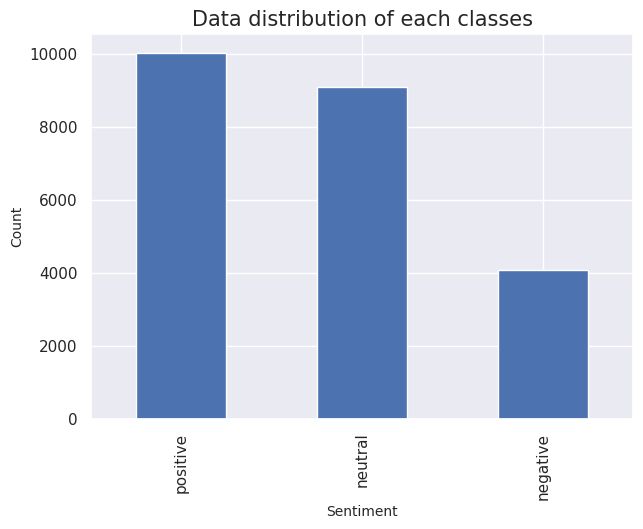

In [12]:
df["sentiment"].value_counts().plot(kind = "bar", figsize = (7, 5))
plt.title("Data distribution of each classes", fontsize = 15)
plt.xlabel("Sentiment", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

In [6]:
df_neg = df[df["sentiment"] == "negative"]
df_pos = df[df["sentiment"] == "positive"].sample(df_neg.shape[0], random_state = 101)
df_neu = df[df["sentiment"] == "neutral"].sample(df_neg.shape[0], random_state = 101)

In [7]:
df_b = pd.concat([df_neg, df_pos, df_neu])

In [15]:
df_b.shape

(12216, 3)

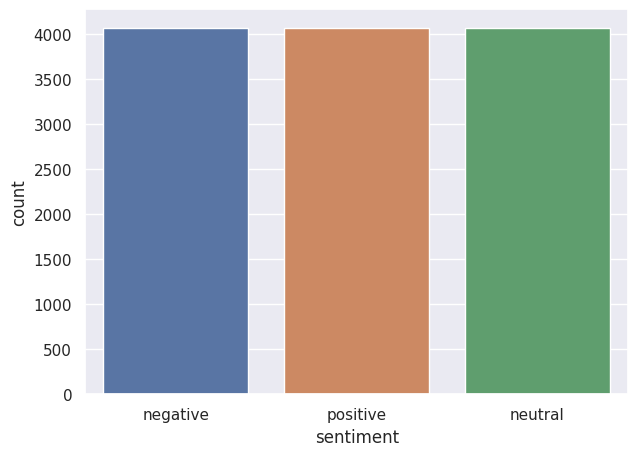

In [16]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_b, x = "sentiment")
plt.show()

In [8]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [9]:
try:
    nltk.download('averaged_perceptron_tagger_eng')
except:
    nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def text_cleaning(text):
    words = clean_words(text, clean_all = False,
                        stemming = False, 
                        lowercase = True,
                        extra_spaces = True,
                        stopwords = True,
                        numbers = True,
                        punct = True,
                        stp_lang = "english"
                       )
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return " ".join(words)

In [12]:
df_b["cleaned_c"] = df_b["Comment"].apply(text_cleaning)

In [22]:
df_b.head()

,Unnamed: 0,Comment,sentiment,cleaned_c
0,0,Them: I don't think I like this game.\n\nMe: B...,negative,dont think like game havent even played minute...
1,1,Then you leave them to farm the smaller creatu...,negative,leave farm small creature either wait help kil...
3,3,"[Also, they're made of paper](https://i.imgur....",negative,also theyre make paperhttpsiimgurcomwyugjjpg e...
14,14,[showing a video game to my nephew for the fir...,negative,show video game nephew first time didnt go wel...
25,25,What about ten minutes in and they say “I’m no...,negative,ten minute say “i’m sure get what’s go eh i’m ...


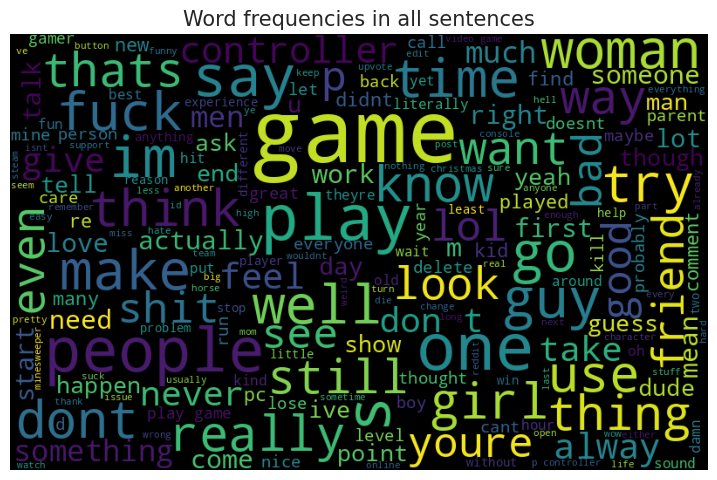

In [23]:
plt.figure(figsize = (9, 7))
all_sents = " ".join([sentence for sentence in df_b["cleaned_c"]])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title("Word frequencies in all sentences", fontsize = 15)
plt.axis("off")
plt.show()

In [24]:
def word_cloud(data, sentiment):
    plt.figure(figsize = (9, 7))
    all_sents = " ".join([sentence for sentence in df_b["cleaned_c"][df_b["sentiment"] == sentiment]])
    word_c = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(word_c)
    plt.title(sentiment, fontsize = 15)
    plt.axis("off")
    plt.show()

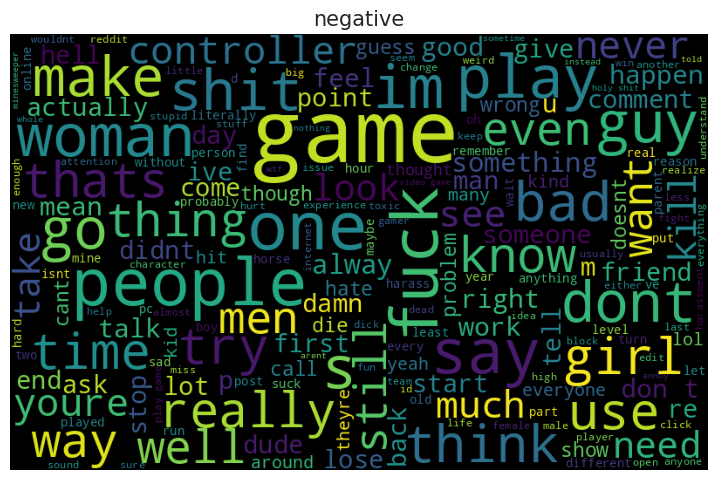

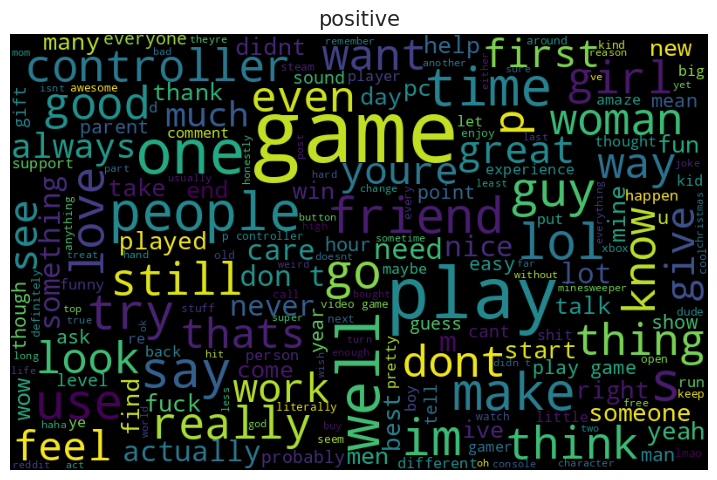

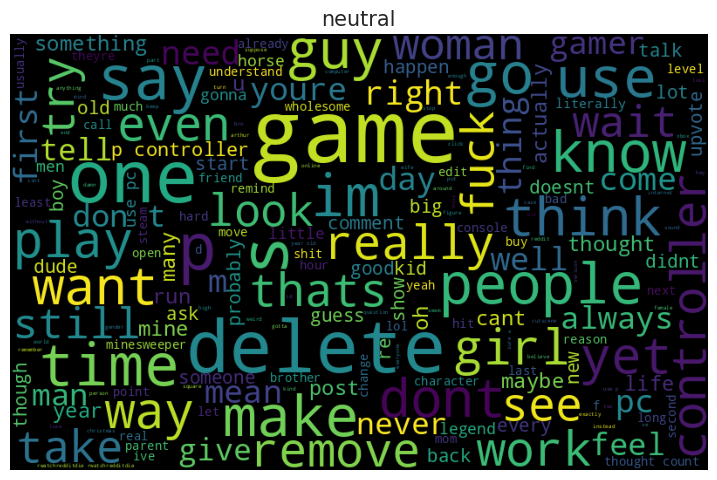

In [25]:
for sentiment in df_b["sentiment"].unique():
    word_cloud(df_b, sentiment)

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_b["cleaned_c"])
seq = tokenizer.texts_to_sequences(df_b["cleaned_c"])

In [14]:
maxlen = max([len(i) for i in seq])
vocab_size = len(tokenizer.word_index) + 1

In [28]:
print(f"Maximum length of sequences: {maxlen}")
print(f"Vocab size: {vocab_size}")

Maximum length of sequences: 332
Vocab size: 12212


In [15]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = "post")

In [16]:
encoder = LabelEncoder()
y = encoder.fit_transform(df_b["sentiment"])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.3, random_state = 101, stratify = y)

In [18]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.4, random_state = 101, stratify = y_test)

In [33]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Validation set size: {len(X_valid)}")

Training set size: 8551
Test set size: 2199
Validation set size: 1466


In [19]:
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [20]:
os.listdir("/kaggle/input/glove-embeddings")

['glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'glove.6B.100d.txt']

In [21]:
embedding_matrix = dict()
glove = open("/kaggle/input/glove-embeddings/glove.6B.100d.txt")
for line in glove:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = "float32")
    embedding_matrix[word] = vector
glove.close()

In [22]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [48]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.062659  ,  0.026003  ,  1.12199998, ...,  0.46125999,
         0.88780999, -0.031292  ],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       ...,
       [ 0.15647   , -0.067234  ,  0.23713   , ..., -0.13516   ,
        -0.48456001, -0.027623  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [34]:
class PaddedTextDataset(Dataset):
    def __init__(self, padded_texts, labels):
        self.padded_texts = padded_texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.padded_texts[index], self.labels[index]

In [35]:
train_dataset = PaddedTextDataset(X_train, y_train)
test_dataset = PaddedTextDataset(X_test, y_test)
valid_dataset = PaddedTextDataset(X_valid, y_valid)

In [36]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)

In [23]:
num_classes = df_b["sentiment"].nunique()
classes = df_b["sentiment"].unique()
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

Number of classes: 3
Classes: ['negative' 'positive' 'neutral']


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [77]:
def plot_results(train_accs, train_losses, valid_accs, valid_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = "Training Accuracy")
    axes[0].plot(xs, valid_accs, label = "Validation Accuracy")
    axes[0].set_title("Training accuracy vs Validation accuracy", fontsize = 15)
    axes[0].set_xlabel("Epoch", fontsize = 10)
    axes[0].set_ylabel("Accuarcy", fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()

    axes[1].plot(xs, train_losses, label = "Training Loss")
    axes[1].plot(xs, valid_losses, label = "Validation Loss")
    axes[1].set_title("Training loss vs Validation loss", fontsize = 15)
    axes[1].set_xlabel("Epoch", fontsize = 10)
    axes[1].set_ylabel("Loss", fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [40]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_loss = 0
    total_acc = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [63]:
def valid_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += criterion(preds, y).item()
            total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [83]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, device = device, patience = 2):
    train_accs, train_losses = [], []
    valid_accs, valid_losses = [], []
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5, verbose=True)
    best_valid_loss = float('inf')
    patience_counter = 0
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device = device)
        valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device = device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        pbar.set_description(f"Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f} | Train Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f}")
    model.load_state_dict(torch.load("best_model.pt"))
    plot_results(train_accs, train_losses, valid_accs, valid_losses)
    return {"train_loss": train_loss, "train_acc": train_acc, "valid_loss": valid_loss, "valid_acc": valid_acc}

In [86]:
class Model1(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim, embedding_vectors, hidden_units):
        super(Model1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_vectors, dtype=torch.float32))

        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(hidden_units * 2, num_classes)   

    def forward(self, x):
        x = self.embedding(x)
        x, (h_n, c_n) = self.lstm(x)
        x = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Train Loss: 0.521 | Valid Loss: 0.668 | Train Acc: 81.862 | Valid Acc: 76.535:  60%|██████    | 6/10 [00:07<00:04,  1.19s/it]

Early stopping at epoch 7


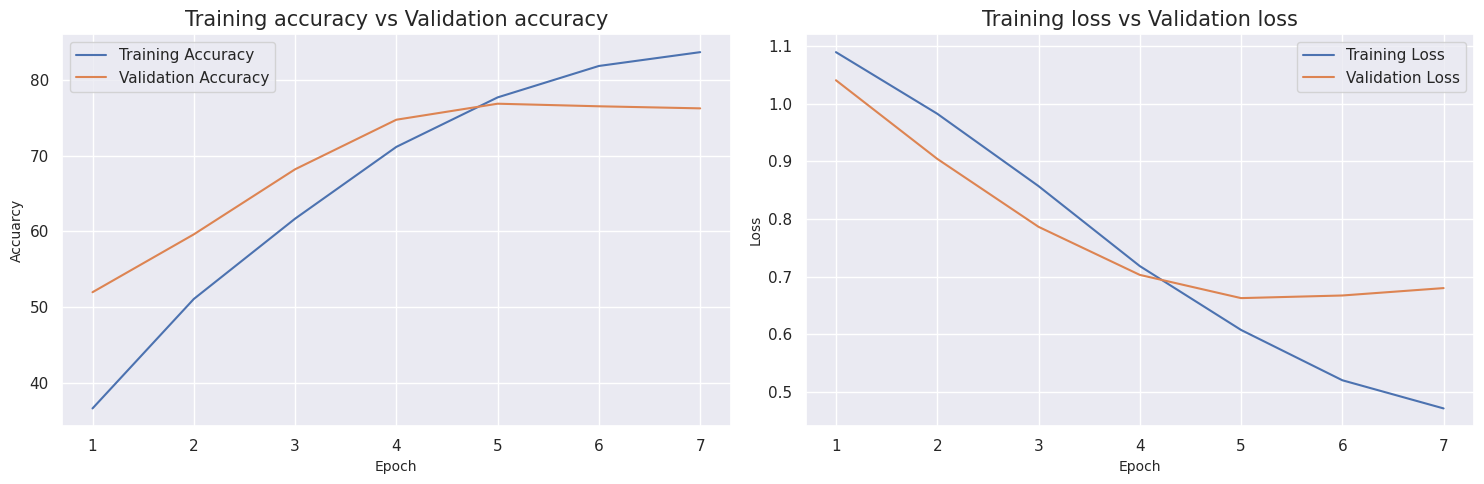

In [90]:
model1 = Model1(num_classes = num_classes, vocab_size = vocab_size, embedding_dim = 100, embedding_vectors = embedding_vectors, hidden_units = 8).to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.001, weight_decay=1e-5)
results = train_model(model1, 10, optimizer, train_loader, valid_loader, device = device)

In [93]:
criterion = nn.CrossEntropyLoss()
t_label, p_label = [], []
total_loss = 0
total_acc = 0

model1.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model1(x)
        total_loss += criterion(preds, y).item()
        total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
        t_label.extend(y.cpu().numpy())
        p_label.extend(preds.argmax(1).cpu().numpy())

test_loss = total_loss / len(test_loader)
test_acc = 100 * total_acc / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}")


Test Loss: 0.680 | Test Acc: 74.72


In [97]:
print(classification_report(t_label, p_label))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       733
           1       0.77      0.74      0.76       733
           2       0.74      0.80      0.77       733

    accuracy                           0.75      2199
   macro avg       0.75      0.75      0.75      2199
weighted avg       0.75      0.75      0.75      2199



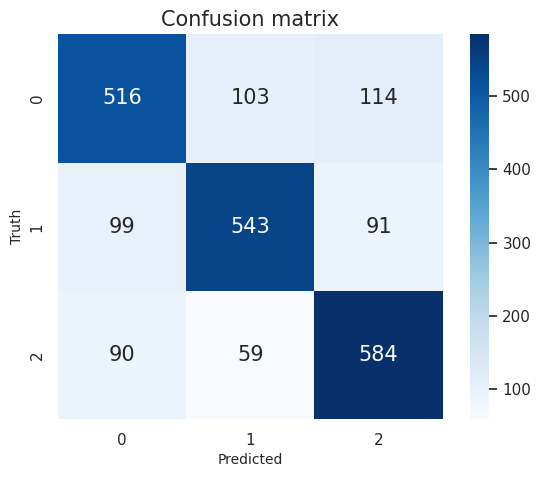

In [99]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(t_label, p_label), annot = True, square = True, cbar = True, annot_kws = {"size": 15}, fmt = "d", cmap = "Blues")
plt.title("Confusion matrix", fontsize = 15)
plt.xlabel("Predicted", fontsize = 10)
plt.ylabel("Truth", fontsize = 10)
plt.show()

In [23]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

In [27]:
model = Sequential()

In [28]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(8)))
model.add(Dense(num_classes, activation = "softmax"))

In [30]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [31]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 2)

In [32]:
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 20, callbacks = [early_stopping])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1756482627.314504     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.4576 - loss: 1.0468 - val_accuracy: 0.6255 - val_loss: 0.8632
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6319 - loss: 0.8575 - val_accuracy: 0.6760 - val_loss: 0.7882
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6784 - loss: 0.7840 - val_accuracy: 0.6965 - val_loss: 0.7616
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6950 - loss: 0.7441 - val_accuracy: 0.6978 - val_loss: 0.7391
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7167 - loss: 0.7118 - val_accuracy: 0.7108 - val_loss: 0.7158
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7345 - loss: 0.6770 - val_accuracy: 0.7156 - val_loss: 0.7059
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7251 - loss: 0.6757 - val_accuracy: 0.7292 - val_loss: 0.7015
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7419 - loss: 0.6539 - val_accuracy: 0.70

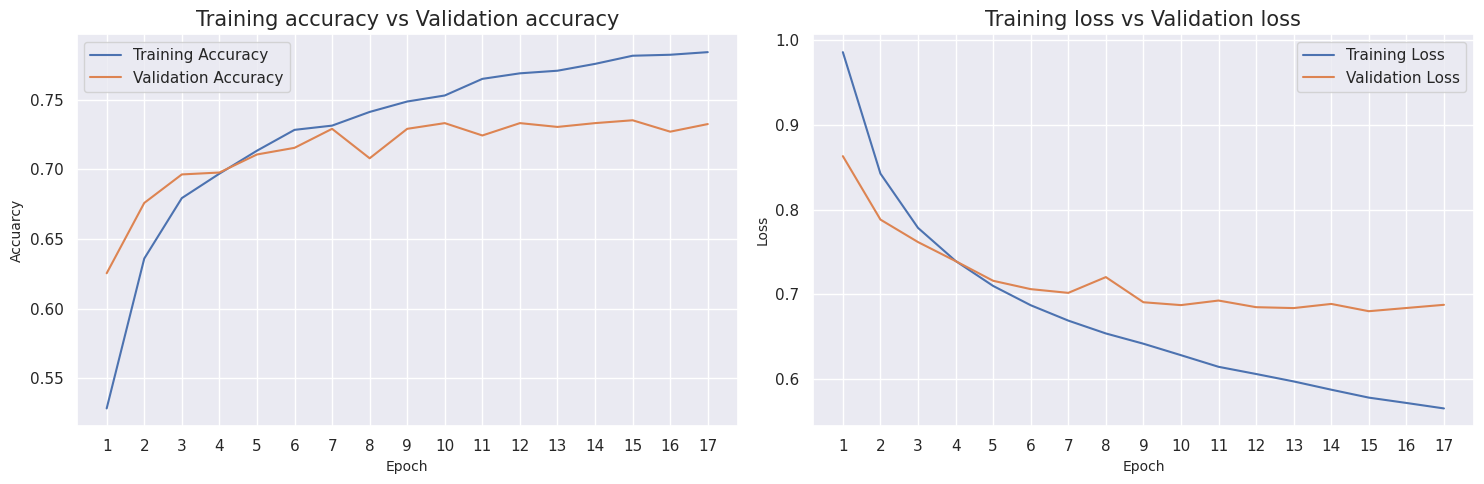

In [35]:
plot_results(history.history["accuracy"], history.history["loss"], history.history["val_accuracy"], history.history["val_loss"])

In [36]:
y_pr = model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [38]:
y_pred = y_pr.argmax(1)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       733
           1       0.77      0.70      0.73       733
           2       0.75      0.74      0.74       733

    accuracy                           0.73      2199
   macro avg       0.74      0.73      0.73      2199
weighted avg       0.74      0.73      0.73      2199



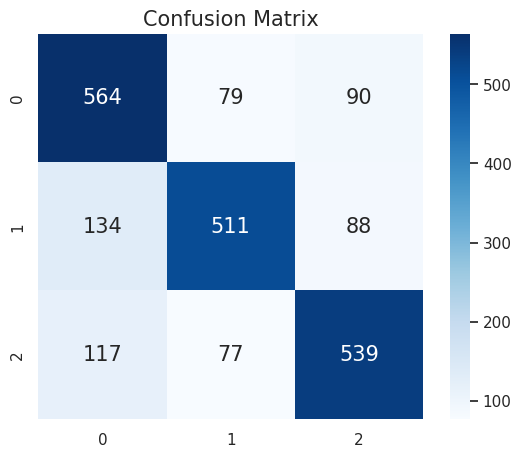

In [41]:
plt.figure(figsize = (7, 5))
plt.title("Confusion Matrix", fontsize = 15)
plt.xlabel("Predicted", fontsize = 10)
plt.ylabel("Truth", fontsize = 10)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cbar = True, square = True, annot_kws = {"size": 15}, fmt = "d", cmap = "Blues")
plt.show()

In [13]:
df_b.head()

,Unnamed: 0,Comment,sentiment,cleaned_c
0,0,Them: I don't think I like this game.\n\nMe: B...,negative,dont think like game havent even played minute...
1,1,Then you leave them to farm the smaller creatu...,negative,leave farm small creature either wait help kil...
3,3,"[Also, they're made of paper](https://i.imgur....",negative,also theyre make paperhttpsiimgurcomwyugjjpg e...
14,14,[showing a video game to my nephew for the fir...,negative,show video game nephew first time didnt go wel...
25,25,What about ten minutes in and they say “I’m no...,negative,ten minute say “i’m sure get what’s go eh i’m ...


In [44]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_nlp
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [45]:
encoder = LabelEncoder()
y = encoder.fit_transform(df_b["sentiment"])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_b["cleaned_c"], y, test_size = 0.3, random_state = 101, stratify = y)

In [17]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.4, random_state = 101, stratify = y_test)

In [18]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Validation set size: {len(X_valid)}")

Training set size: 8551
Test set size: 2199
Validation set size: 1466


In [57]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [58]:
train_data = (train_data.shuffle(buffer_size = len(X_train)).batch(64).cache().prefetch(tf.data.AUTOTUNE))
test_data = (test_data.shuffle(buffer_size = len(X_test)).batch(64).cache().prefetch(tf.data.AUTOTUNE))
valid_data = (valid_data.shuffle(buffer_size = len(X_valid)).batch(64).cache().prefetch(tf.data.AUTOTUNE))

In [59]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_small_en_uncased")

In [60]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer,
    sequence_length = 64,
    truncate = "round_robin"
)

In [71]:
bert_model = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased",
    preprocessor = preprocessor,
    num_classes = num_classes,
    dropout = 0.6
)

In [53]:
#bert_model.backbone.trainable = False

In [72]:
bert_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [73]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 2, restore_best_weights=True)

In [74]:
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 1, min_lr = 1e-6)

In [75]:
history = bert_model.fit(train_data, validation_data = valid_data, epochs = 15, callbacks = [early_stopping, reduce_lr])

Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 66s 273ms/step - accuracy: 0.4862 - loss: 1.0026 - val_accuracy: 0.7251 - val_loss: 0.6908 - learning_rate: 3.0000e-05
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.7313 - loss: 0.6784 - val_accuracy: 0.7804 - val_loss: 0.5957 - learning_rate: 3.0000e-05
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.7901 - loss: 0.5531 - val_accuracy: 0.7954 - val_loss: 0.5661 - learning_rate: 3.0000e-05
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.8320 - loss: 0.4653 - val_accuracy: 0.8049 - val_loss: 0.5660 - learning_rate: 3.0000e-05
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.8578 - loss: 0.3995 - val_accuracy: 0.8056 - val_loss: 0.5766 - learning_rate: 3.0000e-05
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.8864 - loss: 0.3250 - val_accuracy: 0.8015 - val_loss: 0.6156 - learning_rate: 1.5000e-05


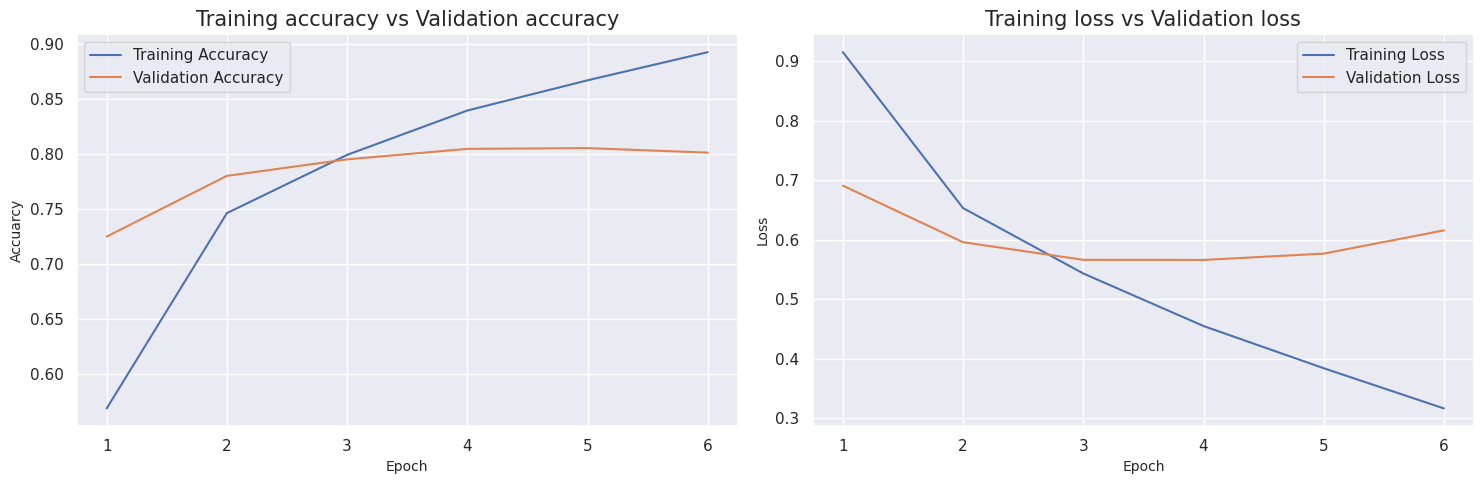

In [78]:
plot_results(history.history["accuracy"], history.history["loss"], history.history["val_accuracy"], history.history["val_loss"])

In [79]:
bert_model.evaluate(X_test, y_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7809 - loss: 0.5908


[0.5941026210784912, 0.7776262164115906]

In [80]:
y_p = bert_model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


In [82]:
y_pred = y_p.argmax(1)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       733
           1       0.82      0.73      0.77       733
           2       0.77      0.83      0.80       733

    accuracy                           0.78      2199
   macro avg       0.78      0.78      0.78      2199
weighted avg       0.78      0.78      0.78      2199



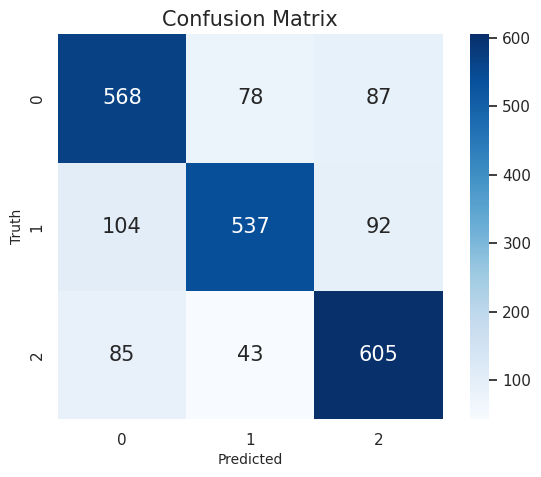

In [85]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cbar = True, square = True, annot_kws = {"size": 15}, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix", fontsize = 15)
plt.xlabel("Predicted", fontsize = 10)
plt.ylabel("Truth", fontsize = 10)
plt.show()